# Purpose
This notebook exists so that I can familiarise myself with the PyTorch pre-trained model API

In [1]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.tensorboard import SummaryWriter
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights
import torchvision.transforms.functional as F
import torchvision.transforms as T

from models.fcn_factory import FcnFactory
from preprocess.loaders import make_hou_loader
from preprocess.transforms import one_hot

In [2]:
# Initialise the model with the latest weights
weights = FCN_ResNet50_Weights.DEFAULT
model = fcn_resnet50(weights=weights)

In [3]:
print(model)

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

In [4]:
# This pretrained model already has several pixel-wise 
# classification classes.
weights.meta["categories"]

['__background__',
 'aeroplane',
 'bicycle',
 'bird',
 'boat',
 'bottle',
 'bus',
 'car',
 'cat',
 'chair',
 'cow',
 'diningtable',
 'dog',
 'horse',
 'motorbike',
 'person',
 'pottedplant',
 'sheep',
 'sofa',
 'train',
 'tvmonitor']

In [5]:
len(weights.meta["categories"])

21

The model has been trained to predict the classes above. These classes do not appear to be closely related to the classes I am looking to find: `__background__` and `solar_panel`.
The lower-level representations may still be useful for fine-tuning

In [6]:
num_classes = 2

---
## Save the models to TensorBoard

In [7]:
WRITE_TO_TENSORBOARD = False

In [8]:
mask_transform = T.Compose([T.Resize((520, 520)), T.Lambda(one_hot)])

In [9]:
HOU_DIR = Path('data/Hou')
hou_loader = make_hou_loader(HOU_DIR, mask_transform=mask_transform)
model_input, target = next(iter(hou_loader))
transforms = weights.transforms()

In [10]:
if WRITE_TO_TENSORBOARD:
    with SummaryWriter('runs/model_exploration') as writer:
        writer.add_graph(
            model,
            input_to_model=transforms(model_input),
            # verbose=True,
            use_strict_trace=False
        )

In [11]:
if WRITE_TO_TENSORBOARD:
    with SummaryWriter('runs/model_exploration_backbone') as writer:
        writer.add_graph(
            model.backbone,
            input_to_model=transforms(model_input),
            # verbose=True,
            use_strict_trace=False
        )

In [12]:
# The classifier head to replace
for name, module in model.named_modules():
    if name == 'classifier':
        print(module)

FCNHead(
  (0): Conv2d(2048, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.1, inplace=False)
  (4): Conv2d(512, 21, kernel_size=(1, 1), stride=(1, 1))
)


In [13]:
custom_model = FcnFactory(n_classes=2).make_fcn('resnet50')

In [14]:
print(custom_model)

_SimpleSegmentationModel(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (

In [15]:
if WRITE_TO_TENSORBOARD:
    with SummaryWriter('runs/resnet_custom_head') as writer:
        writer.add_graph(
            custom_model,
            input_to_model=transforms(model_input),
            # verbose=True,
            use_strict_trace=False
        )

In [16]:
# Get output from the model
output = model.forward(transforms(model_input))

In [17]:
type(output)

collections.OrderedDict

In [18]:
for k in output.keys():
    print(k)

out
aux


In [19]:
clf_out = output['out']
print(type(clf_out))
print(clf_out.shape)

<class 'torch.Tensor'>
torch.Size([1, 21, 520, 520])


In [20]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [21]:
output = custom_model.forward(transforms(model_input))['out']

In [22]:
def predict(output):
    pred = torch.nn.functional.softmax(output)
    return (pred > 0.5).float()

In [23]:
print(output.shape)
print(predict(output))


torch.Size([1, 2, 520, 520])
tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 1., 1., 1.],
          [0., 0., 0.,  ..., 1., 1., 1.],
          [0., 0., 0.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 0., 0., 0.],
          [1., 1., 1.,  ..., 0., 0., 0.],
          [1., 1., 1.,  ..., 0., 0., 0.]]]])


C:\Users\Adam\AppData\Local\Temp\ipykernel_10060\551409364.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = torch.nn.functional.softmax(output)


C:\Users\Adam\AppData\Local\Temp\ipykernel_10060\551409364.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = torch.nn.functional.softmax(output)


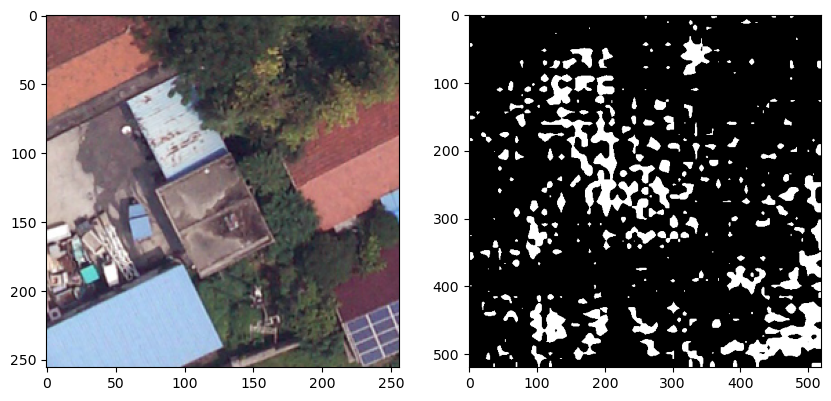

In [24]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axs[0].imshow(F.to_pil_image(model_input[0]))
axs[1].imshow(F.to_pil_image(predict(output[0])))

---
## Testing the output mask shape
- may convert to unit tests later, but want a quick experiment with feedback so I can move on to training a model.

In [25]:
from torch.optim import SGD
from torch.nn import CrossEntropyLoss

In [26]:
optimiser = SGD(custom_model.parameters())
optimiser.zero_grad()

In [27]:
output = custom_model(transforms(model_input))['out']
output.shape

torch.Size([1, 2, 520, 520])

In [28]:
# `target.shape` now matches `output.shape` is not
target.shape

torch.Size([1, 2, 520, 520])

In [29]:
# Cross-entropy loss now works without errors
loss = CrossEntropyLoss()
loss(output, target)

tensor(0.9162, grad_fn=<DivBackward1>)

In [30]:
optimiser.step()

After creating a one-hot encoding function for the targets, one step of a training cycle will now run without error.